Alireza Sabounchi 401212454

### Notebook Description

**U-Net Image Segmentation**

This notebook is designed to implement and understand the U-Net architecture, a deep learning model widely used for image segmentation tasks. The notebook walks through the process of preparing the dataset, building the U-Net model, training it, and evaluating its performance.

**Objectives:**
1. Understand the fundamentals of image segmentation and why U-Net is a popular choice for this task.
2. Learn how to preprocess and split image datasets for training and testing.
3. Implement the U-Net architecture using PyTorch.
4. Train the model and visualize its predictions to evaluate its effectiveness.

**How to Use This Notebook:**
- The notebook is divided into sections such as data preparation, model definition, training, and evaluation.
- Each section contains code and comments explaining the purpose of the steps.
- Students are encouraged to complete the TODO sections, which guide them to implement missing parts of the code or analyze results.

**What You'll Learn:**
- Practical knowledge of handling image datasets.
- Building and customizing a U-Net model.
- Evaluating deep learning models for segmentation tasks.
- Gaining hands-on experience with PyTorch.

**Prerequisites:**
- Familiarity with Python and basic programming concepts.
- A basic understanding of deep learning and PyTorch.
- Knowledge of image processing concepts (optional but helpful).

**Tips for Success:**
- Follow the comments and instructions in the code.
- Refer to the provided links and resources to understand U-Net better.
- Experiment with the code to explore how changes affect the results.

---

This introduction can be added as a Markdown cell at the top of the notebook. Let me know if you'd like me to insert it into the notebook directly!

In [1]:
# This cell imports the required libraries and sets up the environment for the U-Net project.
# TODO for Students: Review these imports and identify which libraries are unfamiliar to you. Research their purpose.

# General libraries for file handling and image processing
import os
import PIL
import time
import glob
import torch
import pickle

# Libraries for data manipulation and visualization
import torchvision
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Specific modules for image and path handling
from PIL import Image
from pathlib import Path
from sklearn.model_selection import train_test_split
import random
from torchvision.transforms import functional as TF

In [2]:
!gdown "https://drive.google.com/uc?id=1ffbbyoPf-I3Y0iGbBahXpWqYdGd7xxQQ" -O dataset.tar.gz
# https://drive.google.com/uc?id=1ffbbyoPf-I3Y0iGbBahXpWqYdGd7xxQQ
# https://drive.google.com/uc?id=1ClU3qdAQhWl2GTbr7DajrBqmN7YKM_2L
!tar -xf dataset.tar.gz

Downloading...
From (original): https://drive.google.com/uc?id=1ffbbyoPf-I3Y0iGbBahXpWqYdGd7xxQQ
From (redirected): https://drive.google.com/uc?id=1ffbbyoPf-I3Y0iGbBahXpWqYdGd7xxQQ&confirm=t&uuid=f07a26a4-d729-4dca-aeff-40b23ff10453
To: /kaggle/working/dataset.tar.gz
100%|███████████████████████████████████████| 4.40G/4.40G [00:42<00:00, 102MB/s]


In [3]:
!rm dataset.tar.gz

In [4]:
# Specify the device to be used for computations.
# If a GPU is available, it will use GPU device 1 ("cuda:1"), otherwise it will fall back to the CPU.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
data_folder = Path("dataset")
origins_folder = data_folder / "images"
masks_folder = data_folder / "masks"

In [5]:
class LungDataset(torch.utils.data.Dataset):
    """
    TODO:
    1. Implement a custom PyTorch Dataset for handling lung images and segmentation masks.
    2. Initialize with the list of image-mask pairs, the origins and masks folders, and optional transformations.
    """
    def __init__(self, origin_mask_list, origins_folder, masks_folder, transforms=None):
        """
        TODO: Initialize the dataset with:
        - `origin_mask_list`: List of (image_name, mask_name) pairs.
        - `origins_folder`: Path to the folder containing the original images.
        - `masks_folder`: Path to the folder containing the masks.
        - `transforms`: Optional transformations to apply.
        """
        self.origin_mask_list = origin_mask_list
        self.origins_folder = origins_folder
        self.masks_folder = masks_folder
        self.transforms = transforms
        
    def __getitem__(self, idx):
        """
        TODO:
        1. Retrieve the image and mask pair based on the provided index `idx`.
        2. Load the image and mask using `Image.open` and convert them if necessary.
        3. Apply the provided transformations if any.
        4. Normalize the image and convert the mask to a binary tensor.
        5. Return the preprocessed image and mask tensors.
        """
        image_name, mask_name = self.origin_mask_list[idx]
        origin_path = os.path.join(self.origins_folder, f"{image_name}.png")
        mask_path = os.path.join(self.masks_folder, f"{mask_name}.png")
        # print(origin_path, mask_path)
        origin = Image.open(origin_path).convert("P")#.convert("P") .convert("RGB")
        mask = Image.open(mask_path)#.convert("L")

        if self.transforms:
            origin, mask = self.transforms((origin, mask))

        origin = TF.to_tensor(origin)
        
        # gray_arr = np.array(origin, dtype=np.float32)
        origin = TF.normalize(origin, mean=0, std=1)
        # origin = (origin - 0.5)/0.5 # normalize

        # origin = Image.fromarray((normal_arr *255).astype(np.uint8))
        
        # mask = np.array(mask)
        mask = (torch.tensor(np.array(mask)) > 128).long() # binarize
        
        return origin, mask

    def __len__(self):
        """
        TODO: Return the total number of image-mask pairs in the dataset.
        """
        return len(self.origin_mask_list)


class Pad():
    """
    TODO:
    1. Create a transformation to add random padding to the image and mask.
    2. Initialize with `max_padding` to control the maximum padding size.
    """
    def __init__(self, max_padding):
        self.max_padding = max_padding

    def __call__(self, sample):
        """
        TODO:
        1. Add random padding within the range of `max_padding`.
        2. Ensure the padding is consistent for both the image and the mask.
        3. Experiment with different padding styles or fill values.
        """
        origin, mask = sample

        # # make sure both are tensor
        # if not isinstance(origin, torch.Tensor):
        #     origin = TF.to_tensor(origin)
        # if not isinstance(mask, torch.Tensor):
        #     mask = torch.tensor(np.array(mask) > 0, dtype=torch.float32).unsqueeze(0)  # to binary tensor

        # pad_left = random.randint(0, self.max_padding)
        # pad_right = random.randint(0, self.max_padding)
        # pad_top = random.randint(0, self.max_padding)
        # pad_bottom = random.randint(0, self.max_padding)

        padding = np.random.randint(0, self.max_padding)
        origin = TF.pad(origin, padding)
        mask = TF.pad(mask, padding)

        return origin, mask


class Crop():
    """
    TODO:
    1. Implement a random cropping transformation for images and masks.
    2. Initialize with `max_shift` to control the maximum cropping shift.
    """
    def __init__(self, max_shift):
        self.max_shift = max_shift

    def __call__(self, sample):
        """
        TODO:
        1. Apply random cropping based on top-left and bottom-right shifts.
        2. Ensure the crop dimensions are consistent for both image and mask.
        3. Validate that the cropped dimensions are appropriate.
        """
        origin, mask = sample
        width, height = origin.size

        # random shifts for top-left, bottom-right
        shift_top = random.randint(0, self.max_shift)
        shift_bottom = random.randint(0, self.max_shift)

        # Compute final crop dims
        crop_w = width - shift_top - shift_bottom
        crop_h = height - shift_top - shift_bottom

        if crop_w <= 0 or crop_h <= 0:
            raise ValueError("Invalid crop size!!")

        # Apply crop
        cropped_origin = TF.crop(origin, shift_top, shift_top, crop_h, crop_w)
        cropped_mask = TF.crop(mask, shift_top, shift_top, crop_h, crop_w)

        return cropped_origin, cropped_mask
        #return origin, mask



class Resize():
    """
    TODO:
    1. Implement a transformation to resize the image and mask to a specific output size.
    2. Initialize with `output_size` as a tuple (height, width).
    """
    def __init__(self, output_size):
        self.output_size = output_size

    def __call__(self, sample):
        """
        TODO:
        1. Resize both the image and the mask to the specified output size.
        2. Ensure no distortions occur during resizing unless intentional.
        """
        origin, mask = sample

        # # Convert tensor to PIL 
        # if isinstance(origin, torch.Tensor):
        #     origin = TF.to_pil_image(origin)
        # if isinstance(mask, torch.Tensor):
        #     mask = TF.to_pil_image(mask.squeeze(0))  # remove batch dimension if exists

        # Resize both
        origin = TF.resize(origin, self.output_size)
        mask = TF.resize(mask, self.output_size)
        # print('Resized origin and mask to:', self.output_size)

        # # Convert PIL to tensor
        # origin = TF.to_tensor(origin)
        # mask = torch.tensor(np.array(mask) > 0, dtype=torch.float32).unsqueeze(0)  # Ensure mask is binary

        return origin, mask


def blend(origin, mask1=None, mask2=None):
    """
    TODO:
    1. Create a visualization function to blend the original image with one or two masks.
    2. Convert the image tensor back to a PIL image for visualization.
    3. Blend the masks with different colors and transparency levels.
    """
    # origin = TF.to_pil_image(origin)
 
    # print(f"Origin size: {origin.size}")
    # print(f"Mask1 size: {mask1.size}") 
    # origin = TF.to_pil_image(origin).convert("P")
    temp = TF.to_pil_image(origin).convert("RGB")
    # if mask1 is not None:
    #     mask1 = mask1.convert("L")
    #     mask1 = mask1.point(lambda p: 255 if p > 0 else 0)
    #     img = Image.blend(origin, mask1, alpha=0.5)
    if mask1 is not None:
        mask1 = TF.to_pil_image(torch.cat([torch.zeros_like(origin), torch.stack([mask1.float()]), torch.zeros_like(origin)]))
        img = Image.blend(temp, mask1, alpha=0.3)                     # one-channel tensor

    if mask2 is not None:
        mask2 = TF.to_pil_image(torch.cat([torch.stack([mask2.float()]), torch.zeros_like(origin), torch.zeros_like(origin)]))
        img = Image.blend(img, mask2, alpha=0.2)        # one-channel tensor

    return img


In [6]:
batch_size = 4  # Batch size for training
origins_list = [f.stem for f in origins_folder.glob("*.png")]  # List of image file names
masks_list = [f.stem for f in masks_folder.glob("*.png")]  # List of mask file names
print(len(origins_list))  # Number of images
print(len(masks_list))  # Number of masks

800
704


In [7]:
# Create a list of tuples linking masks to their corresponding images.
origin_mask_list = [(mask_name.replace("_mask", ""), mask_name) for mask_name in masks_list]

# Split data into training, validation, and testing sets.
splits = {}
splits["train"], splits["test"] = train_test_split(origin_mask_list, test_size=0.2, random_state=42)
splits["train"], splits["val"] = train_test_split(splits["train"], test_size=0.1, random_state=42)

In [8]:
# TODO: Implement the validation and testing transformations.
val_test_transforms = torchvision.transforms.Compose([
    Resize((256, 256)),
])
# TODO: Implement the training transformations by including padding, cropping, and resizing.
train_transforms = torchvision.transforms.Compose([
    Pad(10), 
    Crop(20),
    Resize((256, 256))
])

# TODO: Create the datasets for training, validation, and testing.
datasets = {
    "train": LungDataset(splits["train"], origins_folder, masks_folder, transforms=train_transforms),
    "val": LungDataset(splits["val"], origins_folder, masks_folder, transforms=val_test_transforms),
    "test": LungDataset(splits["test"], origins_folder, masks_folder, transforms=val_test_transforms)
}

# TODO: Initialize the dataloaders for each dataset.
dataloaders = {
    "train": torch.utils.data.DataLoader(datasets["train"], batch_size=batch_size, shuffle=True),
    "val": torch.utils.data.DataLoader(datasets["val"], batch_size=batch_size),
    "test": torch.utils.data.DataLoader(datasets["test"], batch_size=batch_size)
}


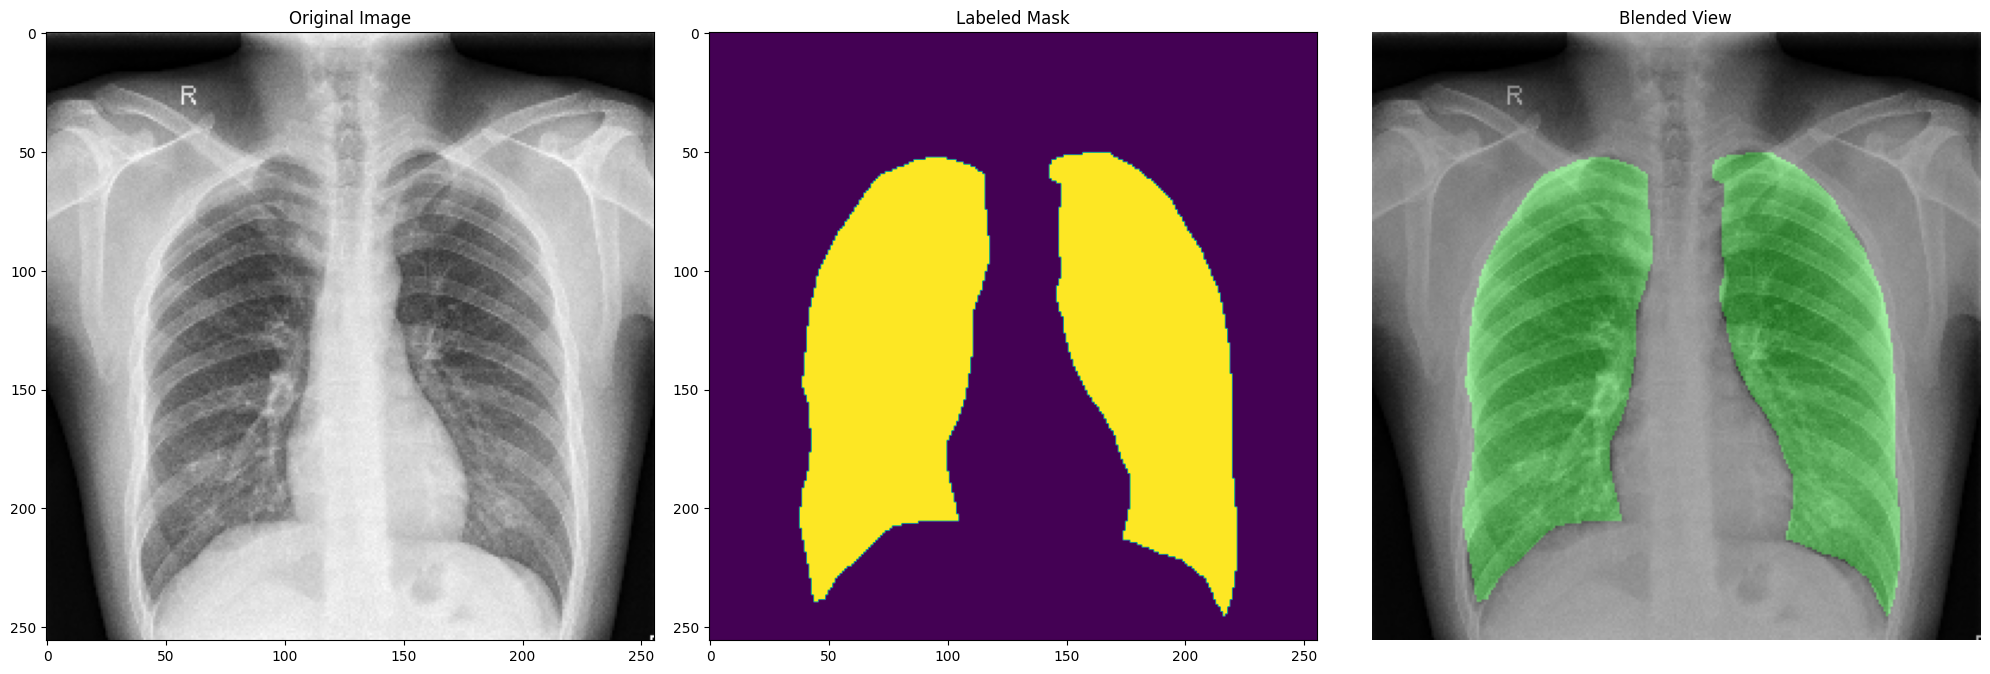

In [9]:
idx = 0
phase = "train"

plt.figure(figsize=(20, 10))
origin, mask = datasets[phase][idx]
# print(origin)
# TODO: Convert the origin and mask tensors to PIL images for visualization.
pil_origin = TF.to_pil_image(origin).convert("RGB")
pil_mask = TF.to_pil_image(mask.float())

# TODO: Plot the original image.
plt.subplot(1, 3, 1)
plt.imshow(pil_origin)
plt.title("Original Image")

# TODO: Plot the manually labeled mask.
plt.subplot(1, 3, 2)
plt.imshow(pil_mask)
plt.title("Labeled Mask")

# TODO: Plot the blended view of the original image and mask.
blended = blend(origin, mask)
# print(origin.shape, mask.shape)

plt.subplot(1, 3, 3)
plt.imshow(blended)
plt.title("Blended View")
plt.axis("off")

plt.tight_layout()
plt.show()


In [10]:
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

In [11]:
class Block(torch.nn.Module):
    def __init__(self, in_channels, mid_channel, out_channels, batch_norm=False):
        super().__init__()
        # TODO: Define the first convolutional layer
        self.conv1 = nn.Conv2d(in_channels, mid_channel, kernel_size=3, padding=1) #kernel_size=3, no dim change pad
        # TODO: Define the second convolutional layer
        self.conv2 = nn.Conv2d(mid_channel, out_channels, kernel_size=3, padding=1)

        self.batch_norm = batch_norm
        if batch_norm:
            # TODO: Define batch normalization layers
            self.bn1 = nn.BatchNorm2d(mid_channel)
            self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        # TODO: Apply the first convolutional layer and batch normalization (if enabled)
        x = self.conv1(x)
        if self.batch_norm:
            x = self.bn1(x)
        x = F.relu(x)

        x = self.conv2(x)
        if self.batch_norm:
            x = self.bn2(x)
        x = F.relu(x)

        return x


class UNet(torch.nn.Module):
    def up(self, x, size):
        # TODO: Implement upsampling
        return F.interpolate(x, size=size, mode=self.upscale_mode)


    def down(self, x):
        # TODO: Implement max pooling for downsampling
        return F.max_pool2d(x, kernel_size=2)

    def __init__(self, in_channels, out_channels, batch_norm=False, upscale_mode="nearest"):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.batch_norm = batch_norm
        self.upscale_mode = upscale_mode

        # TODO: Define encoder blocks
        self.enc1 = Block(in_channels, 64, 64, batch_norm)
        self.enc2 = Block(64, 128, 128, batch_norm)
        self.enc3 = Block(128, 256, 256, batch_norm)
        self.enc4 = Block(256, 512, 512, batch_norm)

        # TODO: Define center block
        self.center = Block(512, 1024, 512, batch_norm)

        # TODO: Define decoder blocks
        self.dec4 = Block(1024, 512, 256, batch_norm)
        self.dec3 = Block(512, 256, 128, batch_norm)
        self.dec2 = Block(256, 128, 64, batch_norm)
        self.dec1 = Block(128, 64, 64, batch_norm)

        # TODO: Define final output layer
        self.out = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        # TODO: Implement forward pass for UNet
         # Encoding path
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.down(enc1))
        enc3 = self.enc3(self.down(enc2))
        enc4 = self.enc4(self.down(enc3))

        # Bottleneck
        center = self.center(self.down(enc4))

        # Decoding path
        dec4 = self.dec4(torch.cat([self.up(center, enc4.shape[2:]), enc4], dim=1))
        dec3 = self.dec3(torch.cat([self.up(dec4, enc3.shape[2:]), enc3], dim=1))
        dec2 = self.dec2(torch.cat([self.up(dec3, enc2.shape[2:]), enc2], dim=1))
        dec1 = self.dec1(torch.cat([self.up(dec2, enc1.shape[2:]), enc1], dim=1))

        return self.out(dec1)


class PretrainedUNet(torch.nn.Module):
    def up(self, x, size):
        # TODO: Implement upsampling
        return F.interpolate(x, size=size, mode=self.upscale_mode)


    def down(self, x):
        # TODO: Implement max pooling for downsampling
        return F.max_pool2d(x, kernel_size=2)

    def __init__(self, in_channels, out_channels, batch_norm=False, upscale_mode="nearest"):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.batch_norm = batch_norm
        self.upscale_mode = upscale_mode

        # TODO: Define initial convolution layer to adjust input channels
        vgg11 = models.vgg11(pretrained=True).features

        # Adjust input channels RGB
        self.init_conv = nn.Conv2d(in_channels=1, out_channels=3, kernel_size=1)


        # TODO: Extract pretrained VGG-11 encoder layers
        self.conv1 = vgg11[0]  
        self.conv2 = vgg11[3]  
        self.conv3 = vgg11[6]  
        self.conv3s = vgg11[8] 
        self.conv4 = vgg11[11] 
        self.conv4s = vgg11[13] 
        self.conv5 = vgg11[16] 
        self.conv5s = vgg11[18]
        
        # TODO: Define center and decoder blocks
        self.center = Block(512, 512, 256, batch_norm)
        
        self.dec5 = Block(768, 512, 256, batch_norm) # From original notebook outputs
        self.dec4 = Block(768, 512, 128, batch_norm)
        self.dec3 = Block(384, 256, 64, batch_norm)
        self.dec2 = Block(192, 128, 32, batch_norm)
        self.dec1 = Block(96, 64, 32, batch_norm)

        # TODO: Define final output layer
        self.out = nn.Conv2d(32, out_channels, kernel_size=1)

    def forward(self, x):
        # TODO: Implement forward pass for Pretrained UNet
 
        x = F.relu(self.init_conv(x))

        # Encoding forward
        enc1 = F.relu(self.conv1(x))
        enc2 = F.relu(self.conv2(self.down(enc1)))
        enc3 = F.relu(self.conv3s(self.conv3(self.down(enc2))))
        enc4 = F.relu(self.conv4s(self.conv4(self.down(enc3))))
        enc5 = F.relu(self.conv5s(self.conv5(self.down(enc4))))

        # Center
        center = self.center(self.down(enc5))

        # Decoding forward
        dec5 = self.dec5(torch.cat([self.up(center, enc5.shape[2:]), enc5], dim=1))
        dec4 = self.dec4(torch.cat([self.up(dec5, enc4.shape[2:]), enc4], dim=1))
        dec3 = self.dec3(torch.cat([self.up(dec4, enc3.shape[2:]), enc3], dim=1))
        dec2 = self.dec2(torch.cat([self.up(dec3, enc2.shape[2:]), enc2], dim=1))
        dec1 = self.dec1(torch.cat([self.up(dec2, enc1.shape[2:]), enc1], dim=1))

        return self.out(dec1)


In [12]:
def jaccard(y_true, y_pred):
    """Calculate Jaccard Index (IoU) for a batch of images."""
    num = y_true.size(0)  # Batch size
    eps = 1e-7  # Small constant to prevent division by zero

    # Flatten the tensors for pixel-wise comparison
    y_true_flat = y_true.view(num, -1)
    y_pred_flat = y_pred.view(num, -1)

    # Calculate intersection and union
    intersection = (y_true_flat * y_pred_flat).sum(1)
    union = ((y_true_flat + y_pred_flat) > 0.0).float().sum(1)

    # Compute Jaccard score
    score = intersection / (union + eps)
    return score.sum() / num  # Average score over batch


def dice(y_true, y_pred):
    """Calculate Dice coefficient (F1 score) for a batch of images."""
    num = y_true.size(0)  # Batch size
    eps = 1e-7  # Small constant to prevent division by zero

    # Flatten the tensors for pixel-wise comparison
    y_true_flat = y_true.view(num, -1)
    y_pred_flat = y_pred.view(num, -1)

    # Calculate intersection
    intersection = (y_true_flat * y_pred_flat).sum(1)

    # Compute Dice score
    score = (2 * intersection) / (y_true_flat.sum(1) + y_pred_flat.sum(1) + eps)
    return score.sum() / num  # Average score over batch


In [13]:
# TODO: Initialize the PretrainedUNet model with appropriate parameters.
unet = PretrainedUNet(
    in_channels=1,  # TODO: Specify the number of input channels
    out_channels=2,  # 1        TODO: Specify the number of output channels
    batch_norm=True,  # TODO: Enable or disable batch normalization
    upscale_mode="nearest"  # TODO: Specify the upsampling mode
)

# TODO: Move the model to the appropriate device (CPU or GPU).
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
unet = unet.to(device)

# TODO: Print the model to verify its structure.
unet
print(unet)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG11_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg11-8a719046.pth" to /root/.cache/torch/hub/checkpoints/vgg11-8a719046.pth
100%|██████████| 507M/507M [00:06<00:00, 81.8MB/s]


PretrainedUNet(
  (init_conv): Conv2d(1, 3, kernel_size=(1, 1), stride=(1, 1))
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3s): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4s): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5s): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (center): Block(
    (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn2): BatchN

In [14]:
# torch.cuda.memory_summary(device=None, abbreviated=False)
# torch.cuda.empty_cache()

In [15]:
# TODO: Set training configurations such as log file, epochs, and optimizer.
train_log_filename = "train_log.txt"  # TODO: Specify log file name
epochs = 20  # TODO: Define the number of epochs
best_val_loss = np.inf
model_name = "unet_best.pth"  # TODO: Specify model checkpoint name
optimizer = torch.optim.Adam(unet.parameters(), lr=1e-4)  # TODO: Initialize optimizer (e.g., Adam)

# TODO: Initialize history list to store training and validation metrics.
hist = []
# bce_loss = torch.nn.BCEWithLogitsLoss()
ce_loss = torch.nn.CrossEntropyLoss()

# def criterion(pred, target, alpha=0):
#     return alpha * bce_loss(pred, target) + (1 - alpha) * (1 - dice(pred, target))


# Training loop
for e in range(epochs):
    start_t = time.time()  # Track the start time of the epoch.

    # Training phase
    # print("train phase")
    print(f"Epoch {e+1}/{epochs} - Training Phase")
    unet.train()
    train_loss = 0.0
    for origins, masks in dataloaders["train"]:
        num = origins.size(0)  # Batch size
        # print(origins.shape)
        # masks = masks.squeeze(2)  # remove the extra dimension if exists
        # print(f"masks shape: {masks.shape}, outs shape: {outs.shape}")

        # TODO: Move input data and targets to the device (CPU or GPU).
        origins = origins.to(device)  # TODO: Move origins to device
        masks = masks.to(device)  # TODO: Move masks to device

        # TODO: Reset gradients and perform forward and backward passes.
        optimizer.zero_grad()

        # Forward pass
        outs = unet(origins)
        # loss = bce_loss(outs.squeeze(1), masks.float())
        loss = ce_loss(outs, masks)

        # Backward pass
        loss.backward()
        optimizer.step()
        
        # TODO: Accumulate training loss for reporting.
        train_loss += loss.item() * num
        print(".", end="")  # Print progress

    train_loss = train_loss / len(datasets['train'])  # Normalize training loss
    print()

    # Validation phase
    print("validation phase")
    unet.eval()
    val_loss = 0.0
    val_jaccard = 0.0
    val_dice = 0.0

    for origins, masks in dataloaders["val"]:
        num = origins.size(0)  # Batch size
        # masks = masks.squeeze(2)
        # TODO: Move validation data and targets to the device.
        origins = origins.to(device)
        masks = masks.to(device)
        
        with torch.no_grad():  # Disable gradient computation for validation.
            outs = unet(origins)  # TODO: Perform forward pass
            # outs = F.log_softmax(outs, dim=1) # TODO: Apply log-softmax
            # loss = bce_loss(outs.squeeze(1), masks.float()) 
            loss = ce_loss(outs, masks)
            val_loss += loss.item() * num  # TODO: Compute validation loss

            # TODO: Compute Jaccard and Dice metrics for evaluation.
            # outs = torch.sigmoid(outs) # NOTE: because out channels = 1 we can binarize results instead of having softmax over 2 channels
            # outs = (outs > 0.5).float()
            outs = torch.softmax(outs, dim=1)
            outs = outs.argmax(dim=1)
            
            val_jaccard += jaccard(masks, outs).item() * num
            val_dice += dice(masks, outs).item() * num

        print(".", end="")  # Print progress
    val_loss /= len(datasets["val"]) # TODO: Normalize validation loss
    val_jaccard /= len(datasets["val"])  # TODO: Normalize Jaccard score
    val_dice /= len(datasets["val"])  # TODO: Normalize Dice score
    print()

    end_t = time.time()  # Track the end time of the epoch.
    spended_t = end_t - start_t

    # TODO: Log training and validation metrics.
    with open(train_log_filename, "a") as train_log_file:
        report = f"Epoch {e+1}: Time={spended_t:.2f}s, Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}, Jaccard={val_jaccard:.4f}, Dice={val_dice:.4f}"  # TODO: Format report string

        # TODO: Append metrics to the history list for future analysis.
        hist.append({
            "time": spended_t,
            "train_loss": train_loss,
            "val_loss": val_loss,
            "val_jaccard": val_jaccard,
            "val_dice": val_dice,
        })

        print(report)  # TODO: Print the metrics
        train_log_file.write(report + "\n")  # TODO: Write metrics to the log file
        print()
        # Save model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(unet.state_dict(), model_name)
        print(f"Model saved as {model_name}")


Epoch 1/20 - Training Phase
...............................................................................................................................
validation phase
...............
Epoch 1: Time=114.69s, Train Loss=0.3524, Val Loss=0.2876, Jaccard=0.8742, Dice=0.9315

Model saved as unet_best.pth
Epoch 2/20 - Training Phase
...............................................................................................................................
validation phase
...............
Epoch 2: Time=114.02s, Train Loss=0.2430, Val Loss=0.2177, Jaccard=0.9108, Dice=0.9527

Model saved as unet_best.pth
Epoch 3/20 - Training Phase
...............................................................................................................................
validation phase
...............
Epoch 3: Time=114.07s, Train Loss=0.2023, Val Loss=0.1832, Jaccard=0.9164, Dice=0.9559

Model saved as unet_best.pth
Epoch 4/20 - Training Phase
......................................................

In [16]:
# print(hist)

Total Training Time: 37.97 minutes
Mean Epoch Time: 1.90 minutes


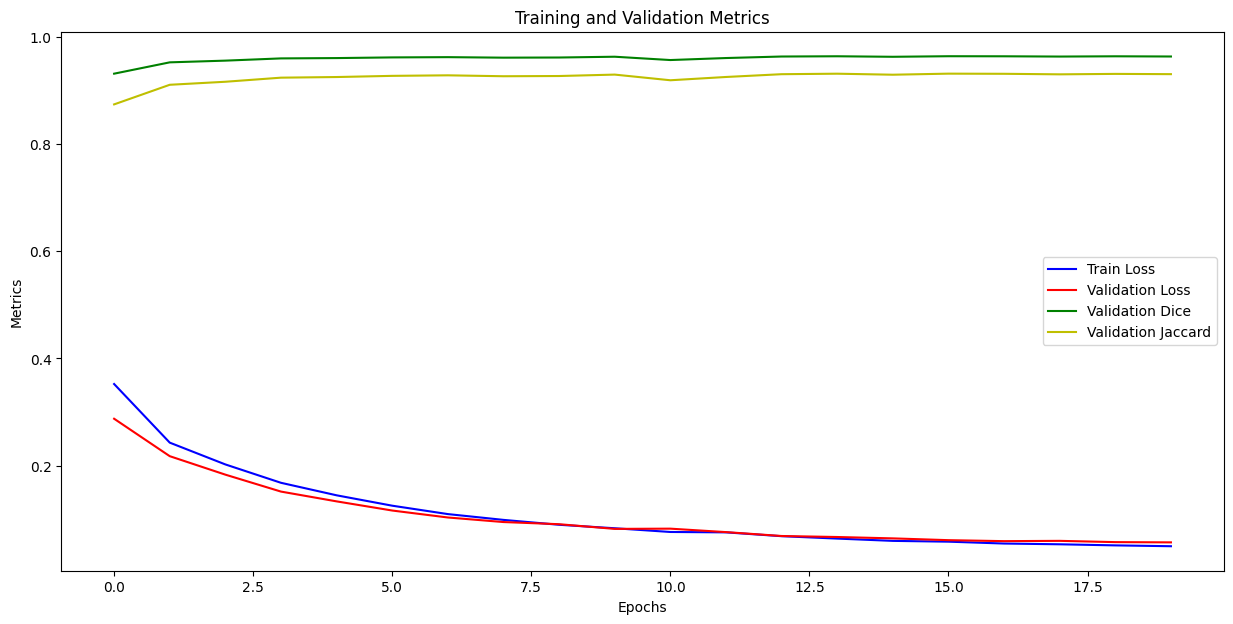

In [17]:
# TODO: Initialize a plot to visualize training and validation metrics.
plt.figure(figsize=(15, 7))
# TODO: Extract and plot training loss history.
train_loss_hist = [h["train_loss"] for h in hist]  # TODO: Extract training loss from `hist`.
plt.plot(range(len(train_loss_hist)), train_loss_hist, "b", label="Train Loss")  # TODO: Plot training loss.

# TODO: Extract and plot validation loss history.
val_loss_hist = [h["val_loss"] for h in hist]  # TODO: Extract validation loss from `hist`.
plt.plot(range(len(val_loss_hist)), val_loss_hist, "r", label="Validation Loss")  # TODO: Plot validation loss.

# TODO: Extract and plot Dice score history.
val_dice_hist = [h["val_dice"].cpu().numpy() if isinstance(h["val_dice"], torch.Tensor) else h["val_dice"] for h in hist]
  # TODO: Extract Dice scores from `hist`.
plt.plot(range(len(val_dice_hist)), val_dice_hist, "g", label="Validation Dice")  # TODO: Plot Dice scores.

# TODO: Extract and plot Jaccard score history.
val_jaccard_hist = [h["val_jaccard"].cpu().numpy() if isinstance(h["val_jaccard"], torch.Tensor) else h["val_jaccard"] for h in hist]  # TODO: Extract Jaccard scores from `hist`.
plt.plot(range(len(val_jaccard_hist)), val_jaccard_hist, "y", label="Validation Jaccard")  # TODO: Plot Jaccard scores.

# TODO: Add labels and legend to the plot.
plt.legend()
plt.xlabel("Epochs")  # TODO: Add label for x-axis.
plt.ylabel("Metrics")
plt.title("Training and Validation Metrics")

# TODO: Compute overall training time and mean epoch time.
time_hist = [h["time"] for h in hist]  # TODO: Extract time per epoch from `hist`.
overall_time = sum(time_hist) / 60  # TODO: Calculate total training time in minutes.
mean_epoch_time = overall_time / len(hist)  # TODO: Calculate mean epoch time.

# TODO: Print summary of training statistics.
print(f"Total Training Time: {overall_time:.2f} minutes")  # TODO: Format and print training statistics.
print(f"Mean Epoch Time: {mean_epoch_time:.2f} minutes")

In [18]:
# TODO: Evaluate the model on the test dataset and compute metrics.
unet.eval()
test_loss = 0.0
test_jaccard = 0.0
test_dice = 0.0

# TODO: Iterate through the test dataloader.
for origins, masks in dataloaders["test"]:
    num = origins.size(0)
    # masks = masks.squeeze(2)
    # TODO: Move data to the device.
    origins = origins.to(device)
    masks = masks.to(device)

    with torch.no_grad():  # Disable gradient calculation for evaluation.
        outs = unet(origins)  # TODO: Perform forward pass
        # outs = F.log_softmax(outs, dim=1) 
        test_loss += ce_loss(outs, masks).item()  # TODO: Compute test loss

        # TODO: Calculate Jaccard and Dice metrics.
        # outs = torch.sigmoid(outs) # binarize mask from 1 channel
        # outs = (outs > 0.5).float()  # TODO: Get class predictions
        outs = torch.softmax(outs, dim=1) # TODO: Apply log-softmax
        outs = outs.argmax(dim=1) # TODO: Get class predictions
        masks = masks.float()  # TODO: Convert masks to float
        test_jaccard += jaccard(masks, outs).item() * num  # TODO: Compute Jaccard
        test_dice += dice(masks, outs).item() * num  # TODO: Compute Dice
    print(".", end="")  # Print progress

# TODO: Compute average metrics.
test_loss /= len(datasets["test"])  # TODO: Calculate average test loss
test_jaccard /= len(datasets["test"]) # TODO: Calculate average Jaccard score
test_dice /= len(datasets["test"])  # TODO: Calculate average Dice score

# TODO: Print the results.
print()
print(f"Test Loss: {test_loss:.4f}")  # TODO: Print test loss
print(f"Test Jaccard Index: {test_jaccard:.4f}") # TODO: Print test Jaccard
print(f"Test Dice Score: {test_dice:.4f}")  # TODO: Print test Dice

....................................
Test Loss: 0.0156
Test Jaccard Index: 0.9263
Test Dice Score: 0.9607


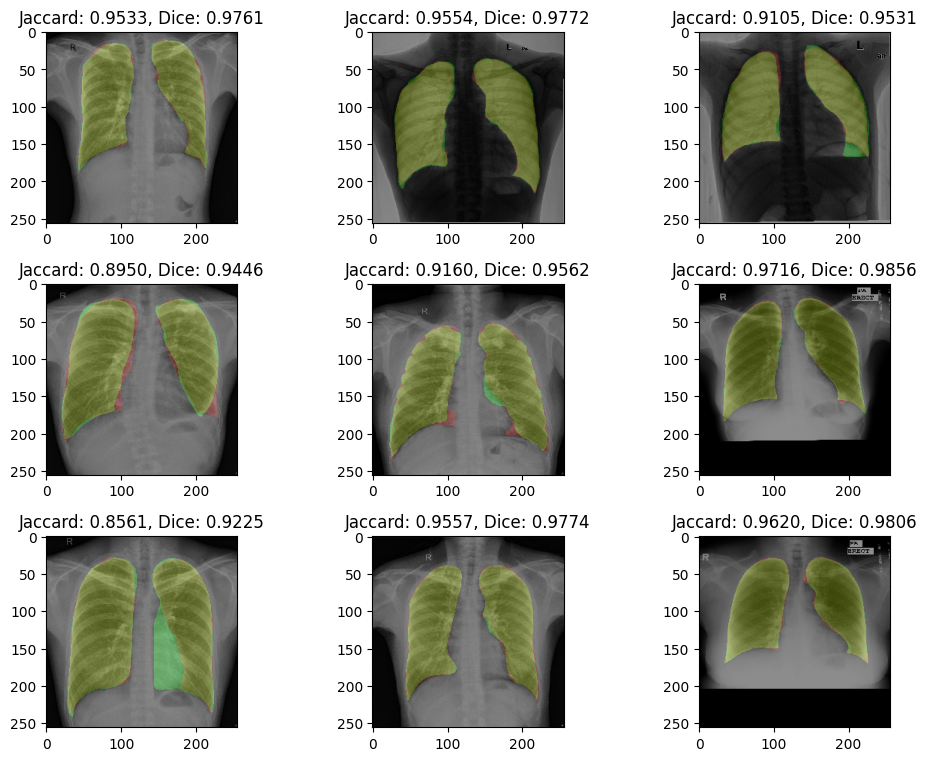


red area - predict
green area - ground truth
yellow area - intersection


In [19]:
# TODO: Visualize predictions on random samples from the test dataset.

# Number of samples to visualize and the dataset phase.
num_samples = 9
phase = 'test'

# TODO: Create a subset of random samples from the specified phase.
random_indices = random.sample(range(len(datasets[phase])), num_samples)
subset = torch.utils.data.Subset(
    datasets[phase],
    random_indices  # TODO: Randomly select indices from the dataset.
)
random_samples_loader = torch.utils.data.DataLoader(subset, batch_size=1)

# TODO: Initialize the figure for visualization.
plt.figure(figsize=(10, 10))  # TODO: Define figure size.

# Iterate through the random samples.
for idx, (origin, mask) in enumerate(random_samples_loader):
    plt.subplot((num_samples // 3) + 1, 3, idx+1)  # TODO: Set subplot grid dimensions.

    # TODO: Move the input data to the appropriate device.
    origin = origin.to(device)
    mask = mask.to(device)

    with torch.no_grad():  # Disable gradient computation for prediction.

        # TODO: Compute evaluation metrics (Jaccard and Dice scores).
        out = unet(origin)  # Perform model inference
        # out = (torch.sigmoid(out)> 0.5).float()
        out = torch.softmax(out, dim=1)
        out = out.argmax(dim=1, keepdim=True).float() 
        jaccard_score = jaccard(mask, out).item()
        dice_score = dice(mask, out).item()

        # TODO: Move data back to the CPU for visualization.
        # origin = origin.cpu().squeeze(0).permute(1, 2, 0).numpy()
        # out = out.cpu().squeeze(0).squeeze(0).numpy()
        # mask = mask.cpu().squeeze(0).squeeze(0).numpy()
        origin = origin[0].to("cpu")
        out = out[0].to("cpu")
        mask = mask[0].to("cpu")

        # TODO: Visualize the blended output (prediction and ground truth).
        # print(origin.shape, mask.shape, out.squeeze(0).shape)
        blended = blend(origin, mask, out.squeeze(0)) 
        plt.imshow(blended)  # Overlay segmentation mask
        plt.title(f"Jaccard: {jaccard_score:.4f}, Dice: {dice_score:.4f}")
plt.tight_layout()
plt.show()

print()
print("red area - predict")
print("green area - ground truth")
print("yellow area - intersection")